In [33]:
import pandas as pd
from sklearn.preprocessing import *
from sklearn_pandas import DataFrameMapper
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = pd.concat([df_train, df_test], axis = 0)

First of all, we examine the dataset for missing values. We print out each column to get a feel for the incompleteness of the data.

In [34]:
print('Missing values per column:')
missing = pd.DataFrame()
for c in range(df_full.shape[1]):
    missing_count = df_full.iloc[:, c].shape[0] - df_full.iloc[:, c].count()  
    if missing_count > 0:
        print(f'{c}:\t{df_full.columns[c]}'
              f' - Missing: {missing_count}'
              f' - # Unique values: {len(df_full.iloc[:, c].value_counts())}')

Missing values per column:
3:	Alley - Missing: 2721 - # Unique values: 2
6:	BsmtCond - Missing: 82 - # Unique values: 4
7:	BsmtExposure - Missing: 82 - # Unique values: 4
8:	BsmtFinSF1 - Missing: 1 - # Unique values: 991
9:	BsmtFinSF2 - Missing: 1 - # Unique values: 272
10:	BsmtFinType1 - Missing: 79 - # Unique values: 6
11:	BsmtFinType2 - Missing: 80 - # Unique values: 6
12:	BsmtFullBath - Missing: 2 - # Unique values: 4
13:	BsmtHalfBath - Missing: 2 - # Unique values: 3
14:	BsmtQual - Missing: 81 - # Unique values: 4
15:	BsmtUnfSF - Missing: 1 - # Unique values: 1135
19:	Electrical - Missing: 1 - # Unique values: 5
23:	Exterior1st - Missing: 1 - # Unique values: 15
24:	Exterior2nd - Missing: 1 - # Unique values: 16
25:	Fence - Missing: 2348 - # Unique values: 4
26:	FireplaceQu - Missing: 1420 - # Unique values: 5
30:	Functional - Missing: 2 - # Unique values: 7
31:	GarageArea - Missing: 1 - # Unique values: 603
32:	GarageCars - Missing: 1 - # Unique values: 6
33:	GarageCond - Missing

There exists a lot of missing values. However, reading the data description, it's clear that the data is very clean and that the missing values are real values not incomplete data. We replace all np.nan values with a placeholder below. The placeholder is 'None' for discrete features or zero for continuous features. We also store the names of continuous and discrete features in order to plot thom.

In [35]:
missing_label = 'None'
cont_feature = []
disc_feature = []
for c in range(df_full.shape[1]):
    if len(pd.value_counts(df_full.iloc[:, c])) > 15 and df_full.iloc[:, c].values.dtype != 'object':
        if df_full.columns[c] not in ('SalePrice', 'Id'):
            df_full.iloc[:, c].fillna(0, inplace = True)
            cont_feature.append(df_full.columns[c])
    else:
        df_full.iloc[:, c].fillna(missing_label, inplace = True)
        disc_feature.append(df_full.columns[c])

We then visualize the relation between each continuous feature and the target variable in order to get a better feel for the data.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


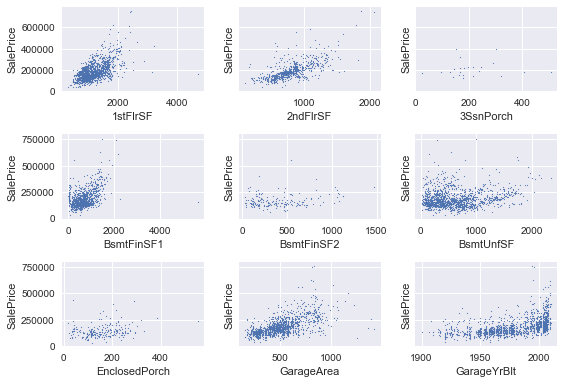

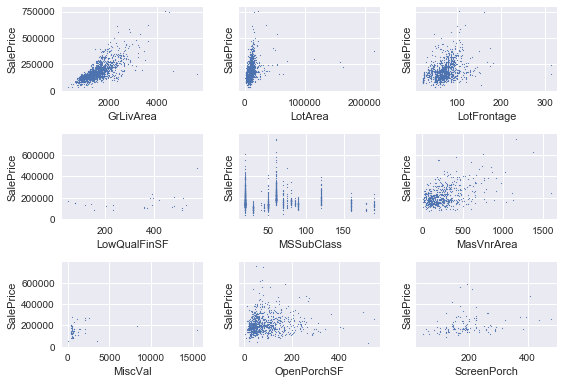

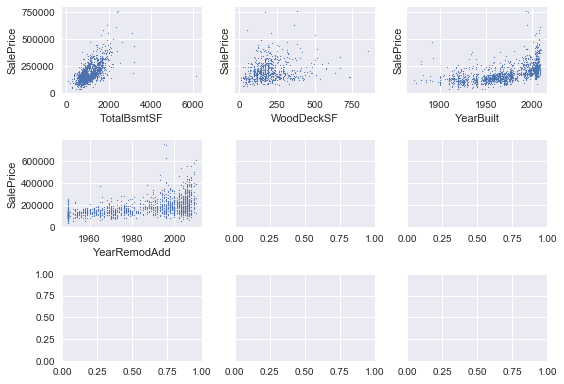

In [36]:
plt.ion()
i = 0
while i < len(cont_feature):
    fig, axs = plt.subplots(nrows = 3,
                            ncols= 3,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(cont_feature): break
        not_na_mask = [x != 0 for x in df_full[cont_feature[i]]]
        ax.scatter(x = df_full[cont_feature[i]].loc[not_na_mask],
                   y = df_full['SalePrice'].loc[not_na_mask],
                   s = 3, marker = '.')
        ax.set_xlabel(cont_feature[i])
        ax.set_ylabel('SalePrice')
        i += 1
    fig.tight_layout()
    fig.show()

We can see from the graphs that most continuous features can be well approximated by a linear or polynomial function. We do the same for discrete features, plotting them in box plots to get a better feel for the data. In addition, we convert the labels to numeric ordinal values. In addition, we move the MoSold and MSSubClass features to the discrete columns to sort them into ordinal values.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


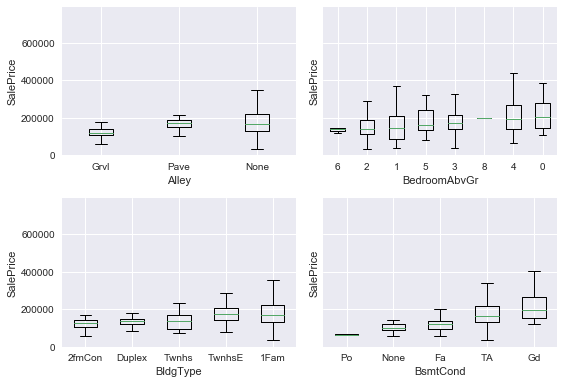

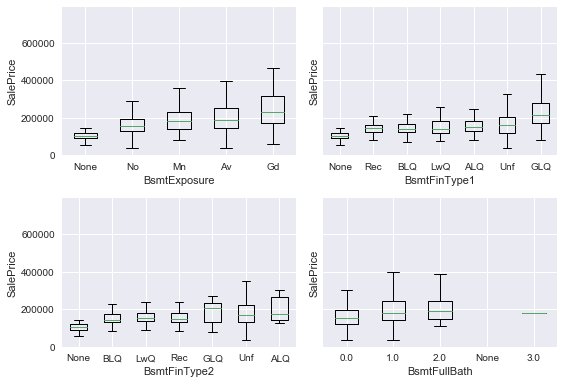

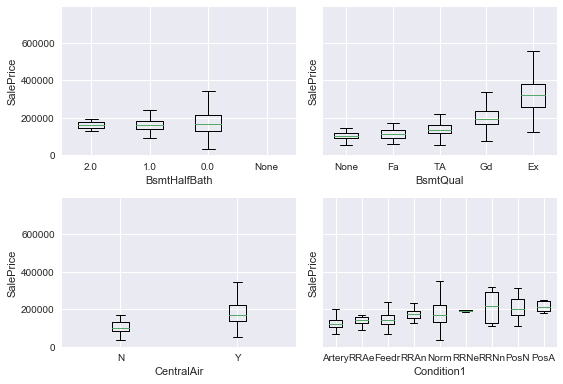

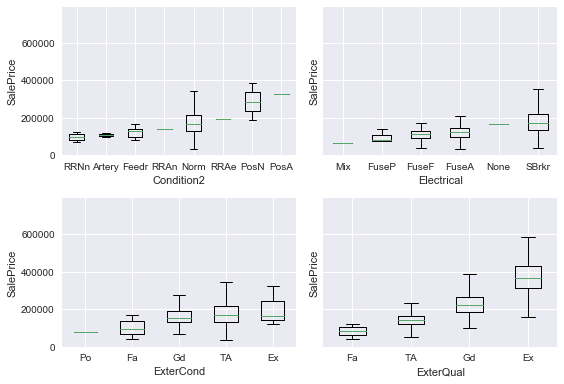

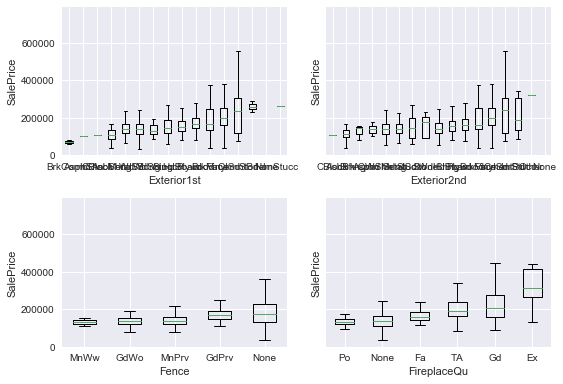

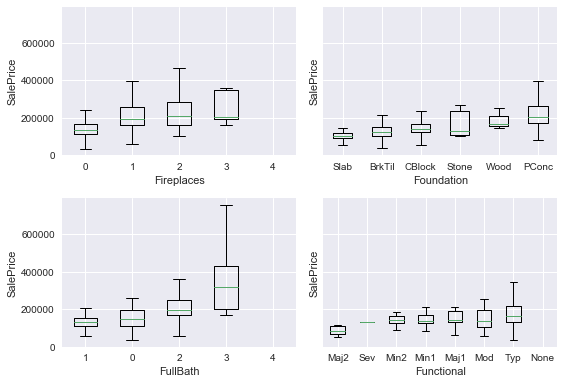

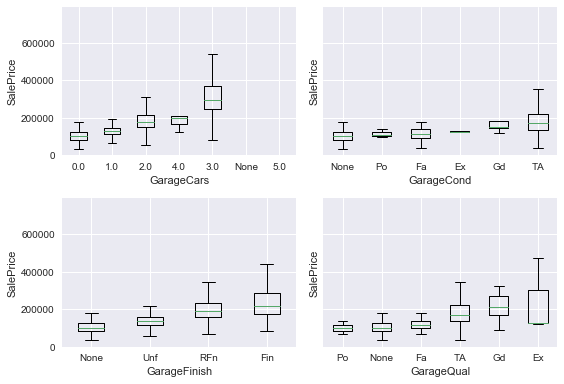

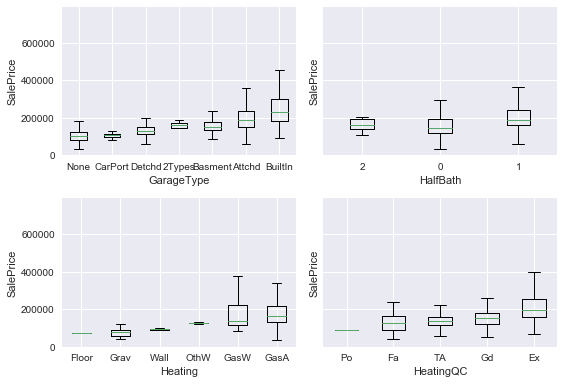

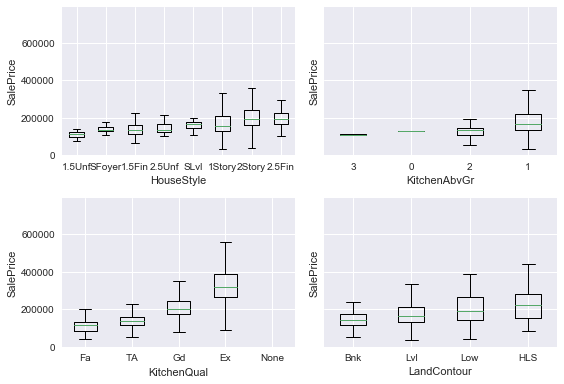

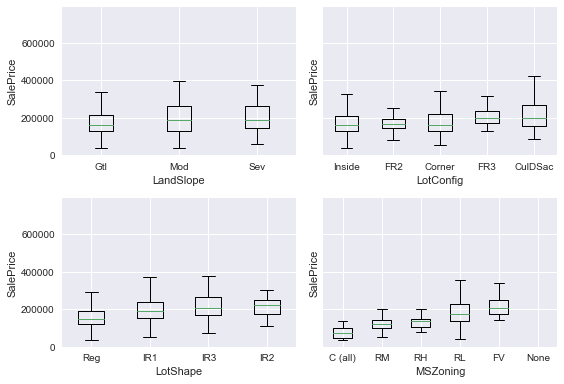

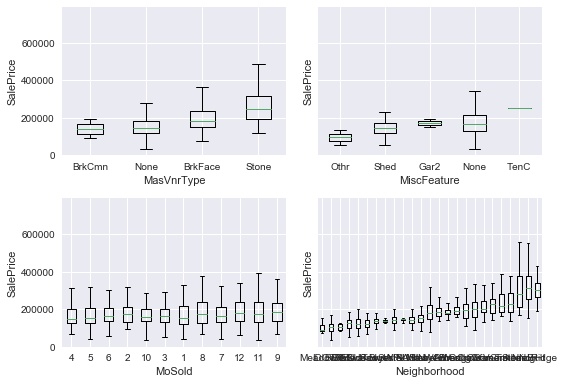

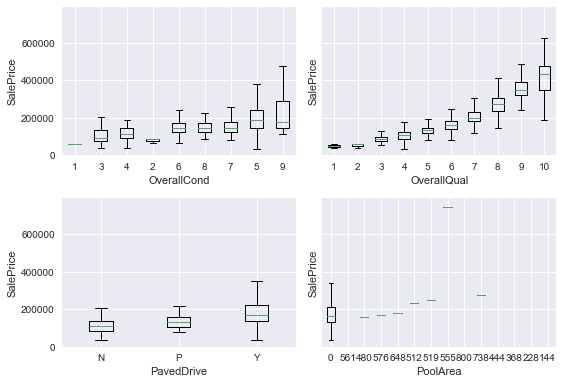

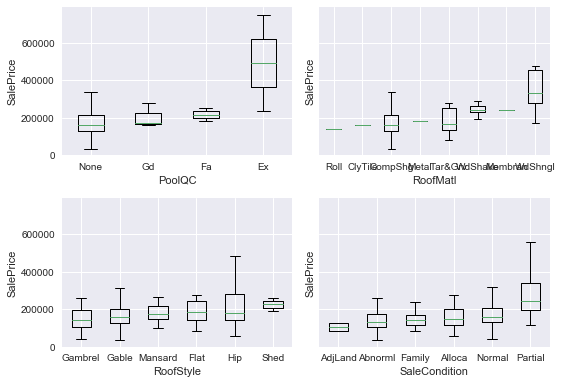

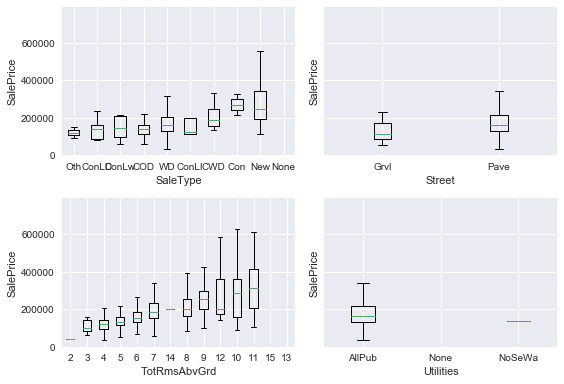

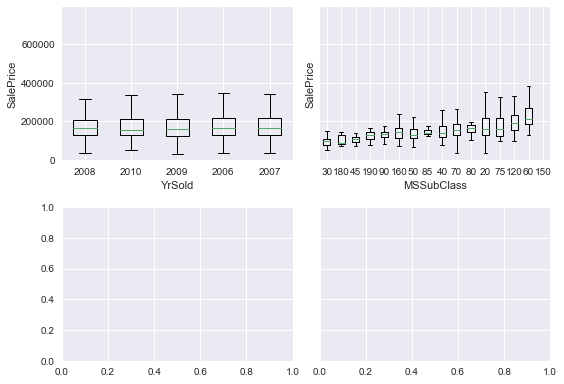

In [37]:
cont_feature.remove('MSSubClass')
disc_feature.append('MSSubClass')
i = 0
while i < len(disc_feature):
    fig, axs = plt.subplots(nrows = 2,
                            ncols= 2,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(disc_feature): break
        categories = df_full[disc_feature[i]].value_counts().index.tolist()
        categories.sort(key = lambda x: df_full['SalePrice'][df_full[disc_feature[i]] == x].mean())
        t = df_full.iloc[:df_train.shape[0], :]
        boxes = [t['SalePrice'][t[disc_feature[i]] == category] for category in categories]
        ax.boxplot(boxes, labels=categories)
        ax.set_xlabel(disc_feature[i])
        ax.set_ylabel('SalePrice')
        
        # Transforming labels into ordinal values sorted according to mean (from above).
        categories = dict(zip(categories, range(len(categories))))
        df_full[disc_feature[i]] = df_full[disc_feature[i]].apply(lambda x: categories[x])
        i += 1
        
    fig.tight_layout()
    fig.show()

Once again, it appears that most features can be modelled with a polynomial function. We can conclude that a linear model will do well on this data, but we'll try different methods as well just to be sure. Next, we standardize the data and plot a PCA scree plot to hopefully reduce the data's dimensionality.

In [38]:
random_seed = 4057585448 # Random seed for reproducibility.

df_train = df_full.iloc[:df_train.shape[0], :]
df_test = df_full.iloc[df_train.shape[0]+1:, :]

X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<p>Due to the smoothness of the scree plot, we cannot project the data into a lower dimension. We will use the full dataset to train our model. Interestingly, a relatively large amount of variance is explained by the first component, however it does not explain enough variance to be useful on its own.</p>
<p>We then do a grid search over a model to test how well our data works with ML algorithms.</p>

In [39]:
for i in range(y_train.shape[0]):
    y_train[i] = math.log(y_train[i])
d_sc = StandardScaler(with_std = False)
print("Error from predicting the mean for all test values:", pd.DataFrame(d_sc.fit_transform((y_train).reshape(-1,1))**2).mean()**.5)

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {(-rf_gs.best_score_)**.5}')
print(rf_gs.best_params_)

Error from predicting the mean for all test values: 0    0.399315
dtype: float64
Grid searching RF model... 


Best score is 0.13963677539944672
{'max_depth': 22}


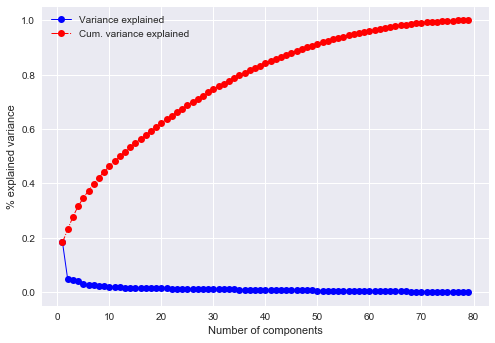

In [40]:
pca = PCA(random_state = random_seed)
pca.fit(X_train)

plt.plot(range(1, X_train.shape[1] + 1),
         pca.explained_variance_ratio_,
         lw=1, color='blue',
         label='Variance explained',
         marker = 'o')
plt.plot(range(1, X_train.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_),
         lw=1, color='red',
         ls='-.', marker = 'o',
         label='Cum. variance explained')
plt.xlabel('Number of components')
plt.ylabel('% explained variance')
plt.legend(loc = 'upper left')
plt.show()

In [41]:
print("Std. for each feature: ")
stds = [(c, df_train.columns[c], df_train.iloc[:, c].std()) for c in range(df_train.shape[1])]
stds.sort(key = lambda x: x[2], reverse = True)
for s in stds:
    print(f'{s[0]}:\t{s[1]}: {s[2]}')

Std. for each feature: 
70:	SalePrice: 79442.50288288663
48:	LotArea: 9981.264932379147
38:	GrLivArea: 525.4803834232027
58:	MiscVal: 496.1230244579311
8:	BsmtFinSF1: 456.09809084092456
37:	GarageYrBlt: 453.6972953893971
15:	BsmtUnfSF: 441.8669552924342
75:	TotalBsmtSF: 438.7053244594705
1:	2ndFlrSF: 436.5284358862591
43:	Id: 421.6100093688479
0:	1stFlrSF: 386.5877380410738
31:	GarageArea: 213.80484145338076
55:	MasVnrArea: 180.73137335812217
9:	BsmtFinSF2: 161.31927280654057
77:	WoodDeckSF: 125.33879435172359
61:	OpenPorchSF: 66.25602767664974
20:	EnclosedPorch: 61.11914860172879
72:	ScreenPorch: 55.757415281874486
52:	LowQualFinSF: 48.623081433519125
50:	LotFrontage: 34.66430423090894
78:	YearBuilt: 30.202904042525265
2:	3SsnPorch: 29.317330556782203
79:	YearRemodAdd: 20.645406807709396
60:	Neighborhood: 6.425884244212347
53:	MSSubClass: 3.884623797213181
59:	MoSold: 3.4192003615624835
24:	Exterior2nd: 3.3576786525637274
23:	Exterior1st: 2.887919828119811
74:	TotRmsAbvGrd: 2.03142925

In [42]:
df_train = df_train.drop([s[1] for s in stds if s[2] < 0.5], axis = 1)
df_test = df_test.drop([s[1] for s in stds if s[2] < 0.5], axis = 1)
print(df_train.shape)

(1460, 63)


In [43]:
g = sns.heatmap(df_train.corr('pearson'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
sns.plt.show()

In [44]:
df_train = df_train.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)
df_test = df_test.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)

In [45]:
corr = [(df_train.columns[c], df_train['SalePrice'].corr(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
corr.sort(key = lambda x: x[1], reverse = True)
for c in corr:
    print(c)

('SalePrice', 0.99999999999999978)
('OverallQual', 0.79098160058380529)
('Neighborhood', 0.69688223975679076)
('ExterQual', 0.68263924165625955)
('KitchenQual', 0.65959972072866235)
('GarageArea', 0.6234314389183615)
('BsmtQual', 0.62292472605884164)
('1stFlrSF', 0.6058521846919146)
('FullBath', 0.55385145575505823)
('TotRmsAbvGrd', 0.53767185987331256)
('YearBuilt', 0.5228973328794968)
('YearRemodAdd', 0.50710096711138619)
('Foundation', 0.50550317128974454)
('GarageType', 0.4891299873675532)
('MSSubClass', 0.47698243019657616)
('MasVnrArea', 0.47261449900457392)
('Fireplaces', 0.46692883675152791)
('HeatingQC', 0.42764870739880345)
('MasVnrType', 0.4236974247903541)
('BsmtFinSF1', 0.38641980624215316)
('BsmtFinType1', 0.38096429719017394)
('BsmtExposure', 0.37469622100088656)
('Exterior1st', 0.37145074216158608)
('SaleType', 0.36682073729680026)
('OverallCond', 0.33036410724017484)
('MSZoning', 0.32460953442313267)
('WoodDeckSF', 0.32441344456812971)
('2ndFlrSF', 0.31933380283206764)

In [46]:
df_train = df_train.drop([c[0] for c in corr if math.fabs(c[1]) < 0.2], axis = 1)
df_test = df_test.drop([c[0] for c in corr if math.fabs(c[1]) < 0.2], axis = 1)

In [48]:
X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
for i in range(y_train.shape[0]):
    y_train[i] = math.log(y_train[i])

print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=GradientBoostingRegressor(),
                      param_grid=[{'learning_rate': [x / 100 for x in range(5, 20, 1)],
                                   'max_depth': [x for x in range(2, 7)],
                                   'max_features': [x / 10 for x in range(1, 11)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {(-gb_gs.best_score_)**.5}')
print(gb_gs.best_params_)
print()

print("Grid searching bagging model...")
bag_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=BaggingRegressor(base_estimator = LinearRegression(),
                                                 n_estimators = 25),
                      param_grid=[{'max_features': [x / 100 for x in range(50, 101, 1)]}])
bag_gs.fit(X_train, y_train)
print(f'Best score is {(-bag_gs.best_score_)**.5}')
print(bag_gs.best_params_)
print()

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(1, 1000, 10)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {(-lasso_gs.best_score_)**.5}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(0, 1000, 10)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {(-ridge_gs.best_score_)**.5}')
print(ridge_gs.best_params_)
print()

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {(-rf_gs.best_score_)**.5}')
print(rf_gs.best_params_)

print("Grid searching KNN model... ")
knn_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=KNeighborsRegressor(),
                      param_grid=[{'n_neighbors': [x for x in range(3, 80)],
                                   'weights': ['uniform', 'distance']}])
knn_gs.fit(X_train, y_train)
print(f'Best score is {(-knn_gs.best_score_)**.5}')
print(knn_gs.best_params_)

Grid searching GB model...
Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.9s


[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   18.8s


[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   39.4s


[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  1.7min


[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  2.4min


[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed:  3.3min


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  4.1min finished


Best score is 0.12788946240026014
{'learning_rate': 0.08, 'max_depth': 5, 'max_features': 0.3}

Grid searching bagging model...
Fitting 10 folds for each of 51 candidates, totalling 510 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.3s


[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   25.3s


[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   50.8s


[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:   59.1s finished


Best score is 0.14470101805605776
{'max_features': 0.84}

Grid searching lasso model...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.5s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.6s finished


Best score is 0.39957101172715537
{'alpha': 1}

Grid searching ridge model...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.4s


[Parallel(n_jobs=-1)]: Done 865 tasks      | elapsed:    6.1s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.7s finished


Best score is 0.14700349808050125
{'alpha': 140}

Grid searching RF model... 
Fitting 10 folds for each of 48 candidates, totalling 480 fits

[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.1s


[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   22.4s


[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   53.2s


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   58.5s finished



Best score is 0.14150745715175986
{'max_depth': 16}
Grid searching KNN model... 
Fitting 10 folds for each of 154 candidates, totalling 1540 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.5s


[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   11.2s


[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   24.4s


[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   44.6s


[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done 1540 out of 1540 | elapsed:  1.5min finished


Best score is 0.17147385002512527
{'n_neighbors': 6, 'weights': 'distance'}
